### EDA on Model Performance
Of the best-performing BERT model (weightedBERT) what were the failure modes? Compare BERT and weightedBERT

In [65]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

from sklearn.datasets import make_classification
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC


In [66]:
from google.colab import drive
drive.mount('/content/drive')
NOTEBOOK_LOC = "/content/drive/MyDrive/Colab Notebooks/W266 Final Project/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [89]:
pd.set_option('display.max_colwidth', 0)

In [67]:
test_data = pd.read_table(NOTEBOOK_LOC + "/Data/GWSD_test.tsv")
test_texts = test_data["sentence"].to_list()
test_labels = np.asarray(test_data["stance_id"].astype(int).to_list())

In [88]:
TARGET_NAMES = ["disagree", "neutral", "agree"]


,Unnamed: 0,Unnamed: 0.1,round,batch,sent_id,sentence,worker_0,worker_1,worker_2,worker_3,...,worker_7,disagree,agree,neutral,guid,in_held_out_test,stance,stance_id,base_pred,weighted_pred
0,10,10,1,0,t13,Evidence now leans against global warming resu...,disagrees,agrees,disagrees,neutral,...,disagrees,0.535462,0.063947,0.400591,1_0_t13,True,disagree,0,1,1
1,19,19,1,0,t21,45 % of the general public view perceived glob...,neutral,neutral,neutral,agrees,...,neutral,0.001904,0.036557,0.961540,1_0_t21,True,neutral,1,1,1
2,22,22,1,0,t24,There is a danger that we can get used to glob...,agrees,agrees,agrees,agrees,...,neutral,0.001625,0.974257,0.024117,1_0_t24,True,agree,2,2,2
3,25,25,1,0,t27,Global warming isn’t happening.,disagrees,disagrees,disagrees,disagrees,...,disagrees,0.997661,0.001168,0.001171,1_0_t27,True,disagree,0,0,0
4,31,31,1,0,t6,Humans have a role and therefore as a matter o...,agrees,agrees,agrees,neutral,...,agrees,0.002485,0.892785,0.104729,1_0_t6,True,agree,2,1,2


In [69]:
 test_pred_baseline = np.argmax(np.load(NOTEBOOK_LOC + '/ModelResults/TestPredictionsBaseline4.npy', allow_pickle=True), axis=1)
 test_pred_weighted = np.argmax(np.load(NOTEBOOK_LOC + '/ModelResults/TestPredictionsWeightedBERT4.npy', allow_pickle=True), axis=1)

In [70]:
test_pred_baseline

array([1, 1, 2, 0, 1, 1, 0, 0, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 2,
       2, 0, 1, 0, 1, 0, 2, 1, 0, 1, 1, 1, 1, 0, 2, 2, 1, 2, 1, 1, 1, 1,
       1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1,
       2, 1, 0, 1, 1, 1, 0, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 2, 0, 1, 2, 0, 2, 1, 0, 1, 1, 1, 2, 2, 1, 1,
       1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 2, 1, 0, 1, 1, 1,
       1, 0, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 0, 1, 0, 2, 0, 0, 1, 2, 2, 0,
       2, 1, 1, 0, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1,
       1, 1])

#### Confusion Matrix Comparison

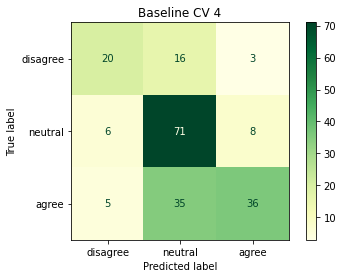

In [71]:
ConfusionMatrixDisplay.from_predictions(test_labels, test_pred_baseline, display_labels = TARGET_NAMES, cmap='YlGn')
plt.title("Baseline CV 4")
plt.savefig(NOTEBOOK_LOC + '/ModelResults/BaselineConfusionMatrixCV4.png')

plt.show()

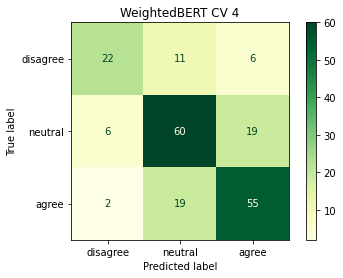

In [72]:
ConfusionMatrixDisplay.from_predictions(test_labels, test_pred_weighted, display_labels = TARGET_NAMES, cmap='YlGn')
plt.title("WeightedBERT CV 4")
plt.savefig(NOTEBOOK_LOC + '/ModelResults/WeightedBERTConfusionMatrixCV4.png')

plt.show()

#### Add columns for base and weighted results

In [107]:
test_data["base_pred"] = test_pred_baseline
test_data["weighted_pred"] = test_pred_weighted

test_data["stance"] = test_data.stance_id.map({0: 'disagree', 1: 'neutral', 2: 'agree'})
test_data["base_stance_pred"] = test_data.base_pred.map({0: 'disagree', 1: 'neutral', 2: 'agree'})
test_data["weighted_stance_pred"] = test_data.weighted_pred.map({0: 'disagree', 1: 'neutral', 2: 'agree'})

test_data.head()

,Unnamed: 0,Unnamed: 0.1,round,batch,sent_id,sentence,worker_0,worker_1,worker_2,worker_3,...,agree,neutral,guid,in_held_out_test,stance,stance_id,base_pred,weighted_pred,base_stance_pred,weighted_stance_pred
0,10,10,1,0,t13,Evidence now leans against global warming resulting from human-related greenhouse gas emissions.,disagrees,agrees,disagrees,neutral,...,0.063947,0.400591,1_0_t13,True,disagree,0,1,1,neutral,neutral
1,19,19,1,0,t21,45 % of the general public view perceived global warming as caused by humans.,neutral,neutral,neutral,agrees,...,0.036557,0.961540,1_0_t21,True,neutral,1,1,1,neutral,neutral
2,22,22,1,0,t24,There is a danger that we can get used to global warming.,agrees,agrees,agrees,agrees,...,0.974257,0.024117,1_0_t24,True,agree,2,2,2,agree,agree
3,25,25,1,0,t27,Global warming isn’t happening.,disagrees,disagrees,disagrees,disagrees,...,0.001168,0.001171,1_0_t27,True,disagree,0,0,0,disagree,disagree
4,31,31,1,0,t6,Humans have a role and therefore as a matter of prudence we ought to have less carbon loading of the\natmosphere.,agrees,agrees,agrees,neutral,...,0.892785,0.104729,1_0_t6,True,agree,2,1,2,neutral,agree


#### What did weighted BERT get wrong?

In [102]:
weighted_wrong = np.not_equal(test_labels, test_pred_weighted)
weighted_mistakes = test_data.merge(test_data[weighted_wrong], how = 'inner')

weighted_mistakes["stance"] = weighted_mistakes.stance_id.map({0: 'disagree', 1: 'neutral', 2: 'agree'})
weighted_mistakes["weighted_stance_pred"] = weighted_mistakes.weighted_pred.map({0: 'disagree', 1: 'neutral', 2: 'agree'})

weighted_mistakes[["sentence", "worker_0", "worker_1", "worker_2", "worker_3", "worker_4", "worker_5", "worker_6", "worker_7", "disagree", "neutral", "agree", "stance_id",  "stance", "weighted_stance_pred"]]

,sentence,worker_0,worker_1,worker_2,worker_3,worker_4,worker_5,worker_6,worker_7,disagree,neutral,agree,stance_id,stance,weighted_stance_pred
0,Evidence now leans against global warming resulting from human-related greenhouse gas emissions.,disagrees,agrees,disagrees,neutral,neutral,disagrees,neutral,disagrees,0.535462,0.400591,0.063947,0,disagree,neutral
1,I am hoping that the scientists and politicians who have been blindly demonizing carbon dioxide for\n37 years will one day open their eyes and look at the evidence.,disagrees,disagrees,agrees,disagrees,disagrees,neutral,disagrees,disagrees,0.966070,0.010665,0.023265,0,disagree,agree
2,Global warming is not expected to end anytime soon.,agrees,neutral,agrees,neutral,neutral,agrees,agrees,neutral,0.004135,0.228778,0.767087,2,agree,disagree
3,The globally averaged sea surface temperature for 2013 is among the 10 warmest on record.,neutral,neutral,agrees,agrees,agrees,neutral,agrees,agrees,0.003535,0.206013,0.790452,2,agree,neutral
4,"Global temperatures in 2014 shattered earlier records, making 2014 the hottest year since record-\nkeeping began in 1880.",agrees,neutral,agrees,agrees,agrees,neutral,agrees,neutral,0.003529,0.207527,0.788944,2,agree,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,There's no one way to talk to people about climate change.,neutral,agrees,agrees,disagrees,neutral,neutral,neutral,disagrees,0.010092,0.983969,0.005939,1,neutral,disagree
59,Democrats and Republicans are not acting more quickly to curb climate change.,neutral,agrees,disagrees,disagrees,agrees,agrees,agrees,agrees,0.011113,0.061360,0.927528,2,agree,neutral
60,Harvard climate action plan explicitly recognizes what the science has made clear.,agrees,agrees,agrees,disagrees,neutral,agrees,agrees,agrees,0.003068,0.019495,0.977438,2,agree,neutral
61,The carbon impact increased sixfold over the period.,neutral,disagrees,neutral,agrees,agrees,agrees,agrees,agrees,0.003814,0.056844,0.939342,2,agree,neutral


#### Of the weighted BERT mistakes, what were especially bad for the case of labeling climate misinformation... so what was labeled "agree" when it should be "disagree"


Only 6 out of what number? 63 mistakes? 200 total samples? 39 disagree support... so 12% fall into this eggregious category... what can we learn from these sentences?

In [129]:
test_data[["sentence", "worker_0", "worker_1", "worker_2", "worker_3", "worker_4", "worker_5", "worker_6", "worker_7", "disagree", "neutral", "agree", "stance_id",  "stance", "base_stance_pred", "weighted_stance_pred"]][(test_data.stance=="disagree")&(test_data.weighted_stance_pred=="agree")]

,sentence,worker_0,worker_1,worker_2,worker_3,worker_4,worker_5,worker_6,worker_7,disagree,neutral,agree,stance_id,stance,base_stance_pred,weighted_stance_pred
7,I am hoping that the scientists and politicians who have been blindly demonizing carbon dioxide for\n37 years will one day open their eyes and look at the evidence.,disagrees,disagrees,agrees,disagrees,disagrees,neutral,disagrees,disagrees,0.966070,0.010665,0.023265,0,disagree,disagree,agree
30,"The fifteen-year long “ global warming ” campaign all along meant “ climate change ” and that this\nin turn means that places supposed to get hotter get hotter and that places that are supposed to get\ncolder — under global warming, er, climate change — get colder.",neutral,disagrees,agrees,agrees,disagrees,neutral,neutral,disagrees,0.706931,0.117723,0.175346,0,disagree,disagree,agree
73,The world is finally on a path toward controlling global warming.,neutral,disagrees,disagrees,disagrees,agrees,neutral,disagrees,neutral,0.692492,0.249896,0.057611,0,disagree,agree,agree
86,Global Warming is a theory and should be taught as such in our schools.,disagrees,disagrees,neutral,neutral,disagrees,disagrees,disagrees,disagrees,0.945406,0.051871,0.002723,0,disagree,neutral,agree
116,"When liberals talk about the dire threat of global warming, liberalsâre actually seizing\nopportunistically on the issue.",agrees,disagrees,agrees,agrees,neutral,agrees,disagrees,neutral,0.439787,0.431305,0.128908,0,disagree,disagree,agree
154,But the erosion of science reaches well beyond the environment and climate.,disagrees,disagrees,disagrees,neutral,neutral,neutral,disagrees,neutral,0.665829,0.330386,0.003786,0,disagree,neutral,agree


#### What did the weighted BERT get right that the Baseline BERT did not?

In [97]:
baseline_wrong = np.not_equal(test_labels, test_pred_baseline)
weighted_correct = np.equal(test_labels, test_pred_weighted)
weighted_improvement = test_data[weighted_correct].merge(test_data[baseline_wrong], how = 'inner')

weighted_improvement["stance"] = weighted_improvement.stance_id.map({0: 'disagree', 1: 'neutral', 2: 'agree'})
weighted_improvement["base_stance_pred"] = weighted_improvement.base_pred.map({0: 'disagree', 1: 'neutral', 2: 'agree'})
weighted_improvement["weighted_stance_pred"] = weighted_improvement.weighted_pred.map({0: 'disagree', 1: 'neutral', 2: 'agree'})

weighted_improvement[["sentence", "worker_0", "worker_1", "worker_2", "worker_3", "worker_4", "worker_5", "worker_6", "worker_7", "disagree", "neutral", "agree", "stance_id",  "stance", "base_stance_pred", "weighted_stance_pred"]]

,sentence,worker_0,worker_1,worker_2,worker_3,worker_4,worker_5,worker_6,worker_7,disagree,neutral,agree,stance_id,stance,base_stance_pred,weighted_stance_pred
0,Humans have a role and therefore as a matter of prudence we ought to have less carbon loading of the\natmosphere.,agrees,agrees,agrees,neutral,agrees,neutral,agrees,agrees,0.002485,0.104729,0.892785,2,agree,neutral,agree
1,The global warming has become a new religion.,disagrees,disagrees,neutral,disagrees,disagrees,disagrees,disagrees,neutral,0.865936,0.130251,0.003813,0,disagree,neutral,disagree
2,Progress in avoiding environmental regrets can come through constructive discussion of ways to cut\nrisks and waste and to sustain a long-term energy quest that extends beyond fossil fuels even while\nthey remain abundant and cheap.,neutral,agrees,agrees,agrees,agrees,agrees,agrees,agrees,0.001907,0.022045,0.976048,2,agree,neutral,agree
3,Global trade merely outsourced U.S. emissions.,disagrees,neutral,neutral,neutral,neutral,neutral,agrees,neutral,0.012022,0.955567,0.032411,1,neutral,disagree,neutral
4,"Sea levels in the Chesapeake Bay are rising at twice the rate of the national average, due to\ngeological sinking and climate change.",agrees,agrees,agrees,agrees,agrees,neutral,agrees,neutral,0.002759,0.082641,0.914600,2,agree,neutral,agree
5,"On the warmest day this month, half the ice sheet’s surface is melting, double the norm for this\ntime of year.",agrees,agrees,agrees,neutral,agrees,agrees,neutral,neutral,0.006701,0.473275,0.520023,2,agree,neutral,agree
6,Global warming helps plants — and thus also helps humans and animals .,disagrees,disagrees,disagrees,disagrees,disagrees,disagrees,disagrees,disagrees,0.998675,0.000598,0.000727,0,disagree,agree,disagree
7,Atmospheric concentrations of carbon dioxide beyond 350 parts-per-million (ppm) could set off\ncompounding feedback loops and so lock us into runaway climate change.,agrees,neutral,neutral,agrees,agrees,disagrees,agrees,neutral,0.004106,0.143817,0.852077,2,agree,neutral,agree
8,"Global-warming science is an echo chamber in which, they contend, it is hard to get published if one\ndoes not accept the conventional wisdom that humans are heating up the planet.",disagrees,disagrees,disagrees,disagrees,disagrees,agrees,disagrees,neutral,0.993556,0.005323,0.001121,0,disagree,neutral,disagree
9,Brown’s carbon-neutral pledge could hurt the state’s economy.,neutral,disagrees,neutral,disagrees,neutral,agrees,disagrees,neutral,0.464579,0.508451,0.026970,1,neutral,disagree,neutral


#### What were the eggregious mistakes from baseline BERT?

In [109]:
test_data[["sentence", "worker_0", "worker_1", "worker_2", "worker_3", "worker_4", "worker_5", "worker_6", "worker_7", "disagree", "neutral", "agree", "stance_id",  "stance", "base_stance_pred", "weighted_stance_pred"]][(test_data.stance=="disagree")&(test_data.base_stance_pred=="agree")]

,sentence,worker_0,worker_1,worker_2,worker_3,worker_4,worker_5,worker_6,worker_7,disagree,neutral,agree,stance_id,stance,base_stance_pred,weighted_stance_pred
59,Global warming helps plants — and thus also helps humans and animals .,disagrees,disagrees,disagrees,disagrees,disagrees,disagrees,disagrees,disagrees,0.998675,0.000598,0.000727,0,disagree,agree,disagree
66,There is a rush to judgment that every time something happens it’s because of global warming.,neutral,disagrees,disagrees,neutral,disagrees,disagrees,disagrees,neutral,0.758483,0.236699,0.004818,0,disagree,agree,neutral
73,The world is finally on a path toward controlling global warming.,neutral,disagrees,disagrees,disagrees,agrees,neutral,disagrees,neutral,0.692492,0.249896,0.057611,0,disagree,agree,agree


#### What eggregious mistakes from baseline BERT were fixed with weighted BERT?





In [106]:
weighted_improvement[["sentence", "worker_0", "worker_1", "worker_2", "worker_3", "worker_4", "worker_5", "worker_6", "worker_7", "disagree", "neutral", "agree", "stance_id",  "stance", "base_stance_pred", "weighted_stance_pred"]][(weighted_improvement.stance=='disagree') & (weighted_improvement.base_stance_pred=='agree')]


,sentence,worker_0,worker_1,worker_2,worker_3,worker_4,worker_5,worker_6,worker_7,disagree,neutral,agree,stance_id,stance,base_stance_pred,weighted_stance_pred
6,Global warming helps plants — and thus also helps humans and animals .,disagrees,disagrees,disagrees,disagrees,disagrees,disagrees,disagrees,disagrees,0.998675,0.000598,0.000727,0,disagree,agree,disagree


#### What did the weighted get wrong that the base got right?
Really what matters here is... what was mis-labeled as "agree" by the weighted BERT? We don't actually care as much if it is a neutral/disagree mixup since one goal of this would be to 

In [96]:
weighted_wrong = np.not_equal(test_labels, test_pred_weighted)
baselined_correct = np.equal(test_labels, test_pred_baseline)
baseline_better = test_data[baselined_correct].merge(test_data[weighted_wrong], how = 'inner')

baseline_better["stance"] = baseline_better.stance_id.map({0: 'disagree', 1: 'neutral', 2: 'agree'})
baseline_better["base_stance_pred"] = baseline_better.base_pred.map({0: 'disagree', 1: 'neutral', 2: 'agree'})
baseline_better["weighted_stance_pred"] = baseline_better.weighted_pred.map({0: 'disagree', 1: 'neutral', 2: 'agree'})

baseline_better[["sentence", "worker_0", "worker_1", "worker_2", "worker_3", "worker_4", "worker_5", "worker_6", "worker_7", "disagree", "neutral", "agree", "stance_id",  "stance", "base_stance_pred", "weighted_stance_pred"]]

,sentence,worker_0,worker_1,worker_2,worker_3,worker_4,worker_5,worker_6,worker_7,disagree,neutral,agree,stance_id,stance,base_stance_pred,weighted_stance_pred
0,I am hoping that the scientists and politicians who have been blindly demonizing carbon dioxide for\n37 years will one day open their eyes and look at the evidence.,disagrees,disagrees,agrees,disagrees,disagrees,neutral,disagrees,disagrees,0.966070,0.010665,0.023265,0,disagree,disagree,agree
1,The Pacific winds are the culprit for slowing global warming.,neutral,neutral,neutral,neutral,neutral,neutral,agrees,agrees,0.002681,0.883341,0.113978,1,neutral,neutral,agree
2,"The fifteen-year long “ global warming ” campaign all along meant “ climate change ” and that this\nin turn means that places supposed to get hotter get hotter and that places that are supposed to get\ncolder — under global warming, er, climate change — get colder.",neutral,disagrees,agrees,agrees,disagrees,neutral,neutral,disagrees,0.706931,0.117723,0.175346,0,disagree,disagree,agree
3,"In other words, to the extent the public believes in the theory humans are responsible for global\nwarming.",disagrees,neutral,neutral,neutral,neutral,neutral,neutral,neutral,0.033568,0.963826,0.002606,1,neutral,neutral,agree
4,"While 64 percent of Americans think global warming is real and caused by human beings, only 44\npercent of evangelicals do.",neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,0.000905,0.997976,0.001119,1,neutral,neutral,agree
5,The Arctic’s albedo may be declining much faster than is estimated only a few years ago.,neutral,neutral,neutral,neutral,neutral,neutral,agrees,agrees,0.002678,0.954782,0.042540,1,neutral,neutral,agree
6,Satellite data disputes global warming.,neutral,disagrees,disagrees,disagrees,disagrees,agrees,disagrees,neutral,0.950846,0.046771,0.002383,0,disagree,disagree,neutral
7,Cosmic rays and the sun play an integral role in global warming.,neutral,disagrees,neutral,neutral,disagrees,disagrees,agrees,neutral,0.200810,0.752472,0.046717,1,neutral,neutral,agree
8,"Development of oil and gas resources in the Arctic would be “incommensurate” with efforts to limit\naverage global warming to 2C. Low oil prices and, perhaps more importantly, oil market volatility.",neutral,neutral,agrees,disagrees,agrees,neutral,neutral,agrees,0.040703,0.839499,0.119797,1,neutral,neutral,agree
9,"Do we really want to open up billions of barrels of high-carbon fuel in Alberta, and put in the\ninfrastructure that will be here for 50 years to access that resource, and let it out into the\nglobal market.",neutral,neutral,neutral,agrees,neutral,neutral,neutral,neutral,0.001831,0.977423,0.020746,1,neutral,neutral,agree


#### Of the eggregious weighted BERT mistakes, did non-weighted BERT get any of them right?

These are the real failures...since weighted BERT got them right

In [105]:
baseline_better[["sentence", "worker_0", "worker_1", "worker_2", "worker_3", "worker_4", "worker_5", "worker_6", "worker_7", "disagree", "neutral", "agree", "stance_id",  "stance", "base_stance_pred", "weighted_stance_pred"]][(baseline_better.stance=='disagree') & (baseline_better.weighted_stance_pred=='agree')]


,sentence,worker_0,worker_1,worker_2,worker_3,worker_4,worker_5,worker_6,worker_7,disagree,neutral,agree,stance_id,stance,base_stance_pred,weighted_stance_pred
0,I am hoping that the scientists and politicians who have been blindly demonizing carbon dioxide for\n37 years will one day open their eyes and look at the evidence.,disagrees,disagrees,agrees,disagrees,disagrees,neutral,disagrees,disagrees,0.966070,0.010665,0.023265,0,disagree,disagree,agree
2,"The fifteen-year long “ global warming ” campaign all along meant “ climate change ” and that this\nin turn means that places supposed to get hotter get hotter and that places that are supposed to get\ncolder — under global warming, er, climate change — get colder.",neutral,disagrees,agrees,agrees,disagrees,neutral,neutral,disagrees,0.706931,0.117723,0.175346,0,disagree,disagree,agree
13,"When liberals talk about the dire threat of global warming, liberalsâre actually seizing\nopportunistically on the issue.",agrees,disagrees,agrees,agrees,neutral,agrees,disagrees,neutral,0.439787,0.431305,0.128908,0,disagree,disagree,agree


In [84]:
baseline_better.stance.value_counts()

neutral     14
disagree     5
Name: stance, dtype: int64

### SpaCy Language Processing

Use Spacy to explore a little deeper... a taste of argument parsing if you will.

Due to time constraints, only apply part of speech tagging to try to analyze the weighted BERT errors. 

Mention that part of speech tagging can also be applied to argument parsing. 


In [111]:
!pip install -U spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [113]:
!pip install -U spacy-lookups-data

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 98.5 MB 80 kB/s 


In [114]:
import spacy

print(spacy.__version__)
print(pd.__version__)

3.4.1
1.3.5


In [115]:
!python -m spacy download en_core_web_lg

2022-07-30 18:39:29.147773: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 587.7 MB 7.2 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [116]:
!python -m spacy download en_core_web_lg

2022-07-30 18:40:32.753240: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 587.7 MB 8.7 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


#### Explore Part of Speech Tagging for Error Analysis

In [118]:
nlp = spacy.load("en_core_web_lg")

In [123]:
weighted_mistakes_sentenes = weighted_mistakes["sentence"].to_list()
weighted_docs = []
for sentence in weighted_mistakes_sentenes:
  doc = nlp(sentence)
  weighted_docs.append(doc)

In [128]:
w266_doc = weighted_docs[0]

df = pd.DataFrame()
df['text'] = [token.text for token in w266_doc]
df['part_of_speech'] = [token.pos_ for token in w266_doc]
df['head'] = [token.head.text for token in w266_doc] 
df['dep'] = [token.dep_ for token in w266_doc]

df

,text,part_of_speech,head,dep
0,Evidence,NOUN,leans,nsubj
1,now,ADV,leans,advmod
2,leans,VERB,leans,ROOT
3,against,ADP,leans,prep
4,global,ADJ,warming,amod
5,warming,NOUN,against,pobj
6,resulting,VERB,warming,acl
7,from,ADP,resulting,prep
8,human,NOUN,related,npadvmod
9,-,PUNCT,related,punct
